# MMMI Oversight Script


**TODO**: Consolidate configuration parameters.

**TODO**: Consolidate population model.

**TODO**: `requirements.txt`

**TODO**: Proper scaling of subdivisions of a quarter

**TODO**: track and display agent histories of consumption and earnings as well as dividend payouts.

**TODO**: Consolidate initial setup to use same scripts as in interim. I.e., by having all agents 'attentive' to start.

**TODO**: Test for expected behavior with maximum attention rating (1)

**TODO**: Begin automated tests

**TODO**: Scale the 'Share' when asset levels adjust due to capital gains (currently the gains are being added to 'risk free' wealth proportional to share).

**TODO**: How do deal with varying 'AdjustPrbs' in quarterly and daily solution steps.

**TODO**: What are the macro population statistics, given our concept of macro agents including institutional investors, etc.

**TODO**: Reduce NL logging/warning in the notebook.

In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
from HARK.Calibration.Income.IncomeTools import (
     sabelhaus_song_var_profile,
)

import logging
from math import exp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:

import hark_portfolio_agents as hpa

import util as UTIL

## Portfolio Consumption Model

Variable | Equation | Operation | Stage | Utility
-- | -- | -- | -- | --
\Risky | ~Dist | Shock | c | --
\TranShk | ~Dist | Shock | c | --
\PermShk | ~Dist | Shock | c | --
\Rport | \Rport = \PortShare * \Risky + (1 - \PortShare) * R | Update | c | --
b | b_{t} = a_{t-1} \RPort | Update | c | --
p | p_{t}=p_{t-1}\PermShk_{t} | Update | c | --
y | y_{t} = p_{t}\TranShk_{t} | Update | c | --
m | m_{t} = b_{t} + y_{t} | Update | c | --
c | c | Control | c | U(c)
a | a_{t} = m_{t} - c_{t} | Update | portshare | --
\PortShare | \PortShare | Control | portshare | 0


## Initialize the Simulation

### Initialize market information

Some initial values for the simulation.

$RAP_0$ is the starting risky asset price. This is adjust after every trading day.

In [3]:
risky_asset_price = 100

HARK uses numerical values for wealth. This variable converts "HARK money" to dollars.

In [4]:
dollars_per_hark_money_unit = 1500

Expected rate of return and standard deviation of the market price process will be updated over time.

These are the starting values, derived from the S&P 500.

$\bar{r}_0 = 0.000628$

$sr_0 = 0.011988$

In [5]:
sp500_ror = 0.000628
sp500_std = 0.011988

market_rate_of_return = sp500_ror
market_standard_deviation = sp500_std

Quarterly dividend rate and standard deviation.

In [6]:
dividend_ror = 0.03
dividend_std = 0.01

Calendar variables. Will ultimately set to be realistic; for now set low for testing.

In [7]:
days_per_quarter = 5 # should be 60
quarters_per_simulation = 4

An attention rate: the chance on any day that an agent will pay attention to the market and trade.

Later, this can be a more realistic function of agent circumstances.

In [8]:
attention_rate = 1.5 / days_per_quarter ## upping this to make more agents engaged in trade

A times we will need to combine the quarterly rates from the price process (capital gains) and the dividends.


### Data stores

For prices, rates or return, and standard deviations over time.

In [9]:
buy_sell_list = []

owned_shares_list = []
total_asset_levels_list = []

### Calculating risky expectations



In [10]:
import math

class FinanceModel():
    """
    A class representing the financial system in the simulation.

    Contains parameter values for:
      - the capital gains expectations function
      - the dividend
      - the risky asset expectations
      
    Contains data structures for tracking ROR and STD over time.
    """
    # Empirical data
    sp500_ror = 0.000628
    sp500_std = 0.011988
    
    # Simulation parameter
    days_per_quarter = 60
    
    # Expectation calculation parameters    
    p1 = 0.1
    delta_t1 = 30

    a = - math.log(p1) / delta_t1

    p2 = 0.1
    delta_t2 = 60

    b = math.log(p2) / delta_t2
    
    # Quarterly dividend rate and standard deviation.
    dividend_ror = 0.03
    dividend_std = 0.01
    
    # Data structures. These will change over time.
    prices = [100]
    ror_list = []

    expected_ror_list = []
    expected_std_list = []
    
    def add_ror(self, ror):
        self.ror_list.append(ror)
        asset_price = self.prices[-1] * (1 + ror)
        self.prices.append(asset_price)
        return asset_price
    
    def __init__(self, dividend_ror = None, dividend_std = None):
        
        if dividend_ror:
            self.dividend_ror = divedend_ror
            
        if dividend_std:
            self.dividend_std = dividend_std
        pass
    
    def calculate_risky_expectations(self):
        """
        Compute the expectations for the risky asset based on historical return rates.
    
        In this implementation there are a number of references to:
          - paramters that are out of scope
          - data structures that are out of scope
     
        These should be bundled together somehow.
        
        NOTE: This MUTATES the 'expected_ror_list' and so in current design
        has to be called on a schedule... this should be fixed.
        """
        # note use of data store lists for time tracking here -- not ideal
        D_t = sum([math.exp(self.a * (l + 1)) for l in range(len(self.ror_list))])
        S_t = math.exp(self.b * (len(self.prices) - 1)) # because p_0 is included in this list.
    
        w_0 = S_t
        w_t = [(1 - S_t) * math.exp(self.a * (t+1)) / D_t for t in range(len(self.ror_list))]
    
        print(f"D_t: {D_t}\nS_t / w_0  : {S_t}") # "\nror_list: {ror_list}\n w_t: {w_t}")
    
        expected_ror = w_0 * self.sp500_ror + sum(
            [w_ror[0] * w_ror[1]
             for w_ror
             in zip(w_t, self.ror_list)])
        self.expected_ror_list.append(expected_ror)
    
        expected_std = math.sqrt(
            w_0 * pow(self.sp500_std, 2) \
            +  sum([w_ror_er[0] * pow(w_ror_er[1] - expected_ror, 2)
                    for w_ror_er
                    in zip(w_t, self.ror_list)]))
        self.expected_std_list.append(expected_std)
    
        print(f'daily expectations: {expected_ror},{expected_std}')

        # expected capital gains quarterly
        ex_cg_q_ror = hpa.ror_quarterly(expected_ror, self.days_per_quarter)
        ex_cg_q_std = hpa.sig_quarterly(expected_std, self.days_per_quarter)
    
        # factor in dividend:
        cg_w_div_ror, cg_w_div_std = hpa.combine_lognormal_rates(
            ex_cg_q_ror,
            ex_cg_q_std,
            self.dividend_ror,
            self.dividend_std
        )
     
        market_risky_params = {
            'RiskyAvg': 1 + cg_w_div_ror,
            'RiskyStd': cg_w_div_std
        }
    
        return market_risky_params
    
    def reset(self):
        """
        Reset the data stores back to original value.
        """
        self.prices = [100]
        self.ror_list = []

        self.expected_ror_list = []
        self.expected_std_list = []

In [11]:
fm = FinanceModel()

fm.calculate_risky_expectations()
fm.reset()

D_t: 0
S_t / w_0  : 1.0
daily expectations: 0.000628,0.011988


### Initialize agents to start

This is to set up the agent parameters and quantities used in the simulation.

`CRRA` refers to the `\rho` parameter in the constant relative risk aversion utility function used by the agents. Utility is over units of resources consumed.

`aNrmInitStd` is normalized initial market assets, standard deviation. The agents' starting wealth is drawn from a lognormal distribution with this standard deviation.

`pLvlInitMean` and `pLvlInitStd` are the mean and standard deviation of the initial level of permanent income of the agents.

In [12]:
## List of tuples: 
##  ( parameters, (i.e. coefficient of relative risk aversion CRRA)
##    number of agents represented,
##    ( initial risky percent, $$$ in risky asset, $$$ in riskless asset)
agent_classes = [
    {
        'CRRA': 2, #2, The level in cstwMPC paper 1.0
        'AgentCount' : 10,
        'aNrmInitMean' : 2
    }] * 10 + \
    [{
        'CRRA': 3, #3, 
        'AgentCount' : 10,
        'aNrmInitMean': 2
    }] * 10 + \
    [{
        'CRRA': 5, #5, 
        'AgentCount' : 10,
        'aNrmInitMean' : 2
    }] * 10 + \
    [{
        'CRRA': 10, #10, 
        'AgentCount' : 10,
        'aNrmInitMean' : 2
    }] * 10 + \
    [{
        'CRRA': 2, #2, 
        'AgentCount' : 10,
        'aNrmInitMean' : 2
    }] * 10


### parameters shared by all agents
agent_parameters = {
    'aNrmInitStd' : 0.0,
    'LivPrb' : [0.98 ** 0.25],
    'PermGroFac': [1.01 ** 0.25],
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0,
    'Rfree' : 1.0,
}

agent_parameters.update(fm.calculate_risky_expectations())
fm.reset()

D_t: 0
S_t / w_0  : 1.0
daily expectations: 0.000628,0.011988


Realistic income shock standard deviations from Sabelhaus and Song:

In [13]:
ssvp = sabelhaus_song_var_profile()

# Assume all the agents are 40 for now.
# We will need to make more coherent assumptions about the timing and age of the population later.
# Scaling from annual to quarterly
idx_40 = ssvp['Age'].index(40)

agent_parameters['TranShkStd'] = [ssvp['TranShkStd'][idx_40] / 2]  # Adjust non-multiplicative shock to quarterly
agent_parameters['PermShkStd'] = [ssvp['PermShkStd'][idx_40] ** 0.25]

In [14]:
len(agent_classes)

50

Initialize the agents.

In [15]:
# This is handling this distribution of discount factors based on cstw_MPC in a hacky way
#      This should be corrected with some HARK updates.
#
#
agents = hpa.create_agents(agent_classes, agent_parameters)

Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized mark

/home/sb/projects/econ-ark/HARK/HARK/core.py:871: RuntimeWarning: invalid value encountered in add
  self.history[var_name] = np.empty((self.T_sim, self.AgentCount)) + np.nan


Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized mark

Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized market resources. Using 1.0 as stopgap.
Agent has no stead say normalized mark

## Get agent risky allocations

Use this stock price to determine the initial number of shares of the risky asset held by each
agent:
 - $RAS_{i0} = (HEC_{i0}.RAW)/ RAP_0$
 
 where RAW is Risky Asset Wealth, amount of resources allocated to the risky asset.
 
 RAS is Risky Asset Shares, number of shares the agent has.

In [16]:
def compute_share_demand(agent):
    """
    Computes the number of shares an agent _wants_ to own.
    
    This involves:
      - Computing a solution function based on their
        expectations and personal properties
      - Using the solution and the agent's current normalized
        assets to compute a share number
    """
    agent.assign_parameters(AdjustPrb = 1.0)
    agent.solve()
    asset_normalized = agent.state_now['aNrm']

    # ShareFunc takes normalized market assets as argument
    risky_share = agent.solution[0].ShareFuncAdj(
        asset_normalized
    )
    
    # denormalize the risky share. See https://github.com/econ-ark/HARK/issues/986
    risky_asset_wealth = risky_share \
                        * asset_normalized \
                        * agent.state_now['pLvl'] \
                        * dollars_per_hark_money_unit 
        
    shares = risky_asset_wealth / risky_asset_price
    
    if (np.isnan(shares)).any():
        print("ERROR: Agent has nan shares")
    
    return shares

## Prepare the main loop

Functions to automate aspects of the main loop.
(Will move this to module code once finalized).



### Activating agents

"At the beginning of each trading day $t + 1$, select a random group of HARK agents with replacement."

**TODO**: HARK AgentType classes represent multiple agents (as many as `AgentCount`). It is difficult to have the agents within the same AgentType act 'separately', though these agents will have _ex ante_ and _ex post_ heterogeneity of some variables. For the purpose of MMMI, we may need to scaffold the agent model to make it easier to have multiple independently acting agents.

In [17]:
import random

def activate(agents, attention_rate):
    """
    Agent attention is set as a boolean flag on the agent class
    with a probability of (attention_rate)
    """
    for agent in agents:
        agent.attentive = random.random() < attention_rate

In [18]:
activate(agents, attention_rate)

"**First**, determine the expected return and standard deviation of the risky asset to be used for decision period $t + 1$."

See `calculate_risky_expectations()`.

"**Second**, using [these expectations] calculate the total number of shares of the risky asset that the selected agents want to buy and sell."

In [19]:
def compute_total_buy_sell(fm, agents):
    """
    Input: a financial model (fm) and a list of agents (agents)
    
    This method does many things:
      - gets new risky expectations
      - loops through the _attentive_ agents and gives them new risky expectations
      - computes their demand
      - mutates the agent to mark the new share quantity
      - computes the total number of shares to be bought/sold this round
    
    NOTE: This MUTATES the agents with their new target share amounts.
    """
    risky_expectations = fm.calculate_risky_expectations()
    
    print(risky_expectations)
    
    buy_shares_total = 0
    sell_shares_total = 0
    
    for agent in agents:
        if agent.attentive:
            # Note: this mutates the underlying agent
            agent.assign_parameters(**risky_expectations)
            
            d_shares = compute_share_demand(agent)
            
            delta_shares = d_shares - agent.shares
            
            # NOTE: This mutates the agent
            agent.shares = d_shares
            
            buy_shares_total += delta_shares[delta_shares > 0].sum()
            sell_shares_total += -delta_shares[delta_shares < 0].sum()
            
    return (round(buy_shares_total), round(sell_shares_total))

In [20]:
#compute_total_buy_sell(agents)

"**Third**, using [total buy and sell shares] as input to the Buy Broker and Sell Broker, run a day of NetLogo trading and determine the end of day price of the risky asset."

See `hpa.run_market`.

"**Fourth**, use the final price to calculate the amount of wealth each (all) HARK agent has allocated to the risky asset."

In [21]:
netlogo_ror = -0.00052125
netlogo_std =  0.0068
simulation_price_scale = 0.25

def daily_rate_of_return(config = None, seed = 0, buy_sell = (0, 0)):
    
    last_sim_price = hpa.get_last_simulation_price(config, seed=seed, buy_sell = buy_sell)
    
    if last_sim_price is None:
        last_sim_price = 400
    
    ror = (last_sim_price * simulation_price_scale - 100) / 100
    
    # adjust to calibrated NetLogo to S&P500
    ror = sp500_std * (ror - netlogo_ror) / netlogo_std + sp500_ror
    
    return ror

In [22]:
def update_agent_wealth(old_share_price, ror):

    new_share_price = old_share_price * (1 + ror)

    for agent in agents:
        market_resources = agent.state_now['mNrm'] * agent.state_now['pLvl']
    
        old_raw = agent.shares * old_share_price
        new_raw = agent.shares * new_share_price
    
        delta_mNrm = (new_raw - old_raw) / \
            (dollars_per_hark_money_unit * agent.state_now['pLvl'])
    
        agent.state_now['aNrm'] = agent.state_now['aNrm'] + delta_mNrm
        
        if (agent.state_now['aNrm'] < 0).any():
            print("ERROR: Agent has NaN aNrm after wealth update from share prices. Setting to 0.")
            agent.state_now['aNrm'][:] = 0.0
        
        agent.state_now['aLvl'] = agent.state_now['aNrm']  * agent.state_now['pLvl']

"Repeat each trading day until the end of the quarter. Then update the economic conditions for each HARK agent (e.g., permanent income level), and repeat [daily loop]."

## Run the main loop



In [23]:
import itertools

seeds = itertools.cycle([0,6,3,2,5,1,4])

config = UTIL.read_config(
    config_file = "../PNL/macroliquidity.ini",
    config_local_file = "../PNL/macroliquidity_local.ini"
)

fm = FinanceModel()

# Main loop
for quarter in range(quarters_per_simulation):
    print(f"Q-{quarter}")

    agent_id = 0
    
    for agent in agents:
        agent_id = agent_id + 1
        #agent.assign_parameters(AdjustPrb = 0.0)
        agent.solve()
        
        ## For risky asset gains in the simulated quarter,
        ## use only the dividend.
        true_risky_expectations = {
            "RiskyAvg" : agent.parameters['RiskyAvg'],
            "RiskyStd" : agent.parameters['RiskyStd']   
        }
        
        dividend_risky_params = {
            "RiskyAvg" : 1 + fm.dividend_ror,
            "RiskyStd" : fm.dividend_std
        }
        
        agent.assign_parameters(**dividend_risky_params)
        
        agent.simulate(sim_periods=1)
        
        ## put back the expectations that include capital gains now
        agent.assign_parameters(**true_risky_expectations)
     
    if quarter == 0:
        for agent in agents:
            agent.shares = compute_share_demand(agent)
            
        owned_shares = sum([sum(agent.shares) for agent in agents])
        print("Owned: " + str(owned_shares))
        owned_shares_list.append(owned_shares)
        
        total_asset_levels = sum(
            [agent.state_now['aLvl'].sum()
             for agent
             in agents]
        ) * dollars_per_hark_money_unit
        print("Total Asset Levels: " + str(total_asset_levels))
        total_asset_levels_list.append(total_asset_levels)

    for day in range(days_per_quarter):
        print(f"Q-{quarter}:D-{day}")
        
        # Set to a number for a fixed seed, or None to rotate
        seed = next(seeds)

        activate(agents, attention_rate)
        buy_sell = compute_total_buy_sell(fm, agents)
        print("Buy/Sell Limit: " + str(buy_sell))
        buy_sell_list.append(buy_sell)
        
        hpa.run_market(config, buy_sell, seed = seed)
        
        ror =  daily_rate_of_return(
            config = config,
            seed = seed,
            buy_sell = buy_sell
        )
        print("ror: " + str(ror))
        
        update_agent_wealth(risky_asset_price, ror)
        
        owned_shares = sum([sum(agent.shares) for agent in agents])
        print("Owned Shares: " + str(owned_shares))
        owned_shares_list.append(owned_shares)
        
        total_asset_levels = sum([agent.state_now['aLvl'].sum()
                                  for agent
                                  in agents]
                                ) * dollars_per_hark_money_unit
        print("Total Asset Levels: " + str(total_asset_levels))
        print("Tot. Owned Share V: " + str(owned_shares * risky_asset_price))
        total_consumption_levels = sum([
            (agent.controls['cNrm'] * agent.state_now['pLvl']).sum() for agent in agents
        ])
        #print("Total Consumption Levels: " + str(total_consumption_levels))
        
        total_asset_levels_list.append(total_asset_levels)
        
        risky_asset_price = fm.add_ror(ror)
        
        print(f"Price end of day {day}: {risky_asset_price}")
        print("") # line break for presentation

config_file: ../PNL/macroliquidity.ini
config_local_file: ../PNL/macroliquidity_local.ini
Q-0
Owned: 7068.87171639395
Total Asset Levels: 706887.1716393941
Q-0:D-0
D_t: 0
S_t / w_0  : 1.0
daily expectations: 0.000628,0.011988
{'RiskyAvg': 1.0695382097810955, 'RiskyStd': 0.09621091290763986}
Buy/Sell Limit: (0, 0)
Output for S:0,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Owned Shares: 7068.87171639395
Total Asset Levels: 711096.1800498564
Tot. Owned Share V: 706887.171639395
Price end of day 0: 100.59542860294117

Q-0:D-1
D_t: 1.0797751623277096
S_t / w_0  : 0.9623506263980885
daily expectations: 0.0008285313326319651,0.011802145880789828
{'RiskyAvg': 1.0824750148330082, 'RiskyStd': 0.09475068069401722}
Buy/Sell Limit: (0, 0)
Output for S:6,BL:0,SL:0 already exists.
Will use cache.
ror: 0.005954286029411765
Owned Shares: 7068.87171639395
Total Asset Levels: 715330.2501002954
Tot. Owned Share V: 711096.1800498578
Price end of day 1: 101.19440255809435

Q-0:D-2
D_

Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (1489, 710)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL1489SL710.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Tick

Elapsed (sys clock), run 1:  58.63221206600001
ror: 0.005954286029411765
Owned Shares: 7847.662488472417
Total Asset Levels: 1014901.7558438438
Tot. Owned Share V: 801341.5533647555
Price end of day 0: 102.72013753966321

Q-1:D-1
D_t: 7.916663826263417
S_t / w_0  : 0.7943282347242815
daily expectations: 0.0014112532122170277,0.010813822012192066
{'RiskyAvg': 1.1209474913145057, 'RiskyStd': 0.08696413038200401}


Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (1195, 573)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL1195SL573.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks:

Elapsed (sys clock), run 4:  28.89645715200001
ror: 0.02799105073529412
Owned Shares: 8469.511391239588
Total Asset Levels: 1039253.6725786874
Tot. Owned Share V: 869989.3750018749
Price end of day 1: 105.5953821210723

Q-1:D-2
D_t: 9.627992130425197
S_t / w_0  : 0.7644222742526002
daily expectations: 0.0025114474414900966,0.011773201242393632
{'RiskyAvg': 1.1972852998320205, 'RiskyStd': 0.09465158575833081}


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (854, 413)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL854SL413.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 0:  22.978541064000012
ror: 0.041213109558823534
Owned Shares: 8910.740025385248
Total Asset Levels: 1078032.447311212
Tot. Owned Share V: 940932.9979620888
Price end of day 2: 109.9472961733339

Q-1:D-3
D_t: 11.475841927847487
S_t / w_0  : 0.7356422544596414
daily expectations: 0.004128810217628678,0.013693988237446305
{'RiskyAvg': 1.318872765752083, 'RiskyStd': 0.11000826788715737}


Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (559, 274)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL559SL274.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 6:  24.199602416999966
ror: 0.0015469330882352942
Owned Shares: 9195.947620137536
Total Asset Levels: 1079596.5042937389
Tot. Owned Share V: 1011069.5765857267
Price end of day 3: 110.11737728374645

Q-1:D-4
D_t: 13.471104242816367
S_t / w_0  : 0.7079457843841379
daily expectations: 0.003962492312409668,0.013408774558296168
{'RiskyAvg': 1.305829591720506, 'RiskyStd': 0.10773344545114827}


Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (284, 125)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL284SL125.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 3:  24.24202927799996
ror: 0.010361638970588236
Owned Shares: 9355.417098731634
Total Asset Levels: 1090271.0025324256
Tot. Owned Share V: 1030193.994307844
Price end of day 4: 111.25837379154869

Q-2
Q-2:D-0
D_t: 15.62553893284825
S_t / w_0  : 0.6812920690579612
daily expectations: 0.004192819119347175,0.013115171193680542
{'RiskyAvg': 1.3239266120189752, 'RiskyStd': 0.10542877998172398}


Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (473, 1191)


nliqsup=90
nlmodeldir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/
nlruncount=5
nlver=5
nmktmkr=5
parallelcores=0
periodtoendexecution=3600
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
--------------------------------------------------------------
NetLogoLink: /home/sb/projects/econ-ark/markets/netlogo-5.3.1-64
NetLogoLink version: 5
NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL473SL1191.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- T

Elapsed (sys clock), run 2:  25.958353851000027
ror: -0.03371189044117648
Owned Shares: 8637.133431550437
Total Asset Levels: 695201.6171783175
Tot. Owned Share V: 960953.4198149202
Price end of day 0: 107.50764368362454

Q-2:D-1
D_t: 17.951844000001877
S_t / w_0  : 0.6556418494179789
daily expectations: 0.0024482123685517624,0.015203300430740162
{'RiskyAvg': 1.192762475714815, 'RiskyStd': 0.12185440390911141}


Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (388, 1035)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD5BL388SL1035.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks:

Elapsed (sys clock), run 5:  23.86544855699998
ror: -0.02489718455882353
Owned Shares: 7990.3253249719455
Total Asset Levels: 673814.4116075098
Tot. Owned Share V: 859021.0479533253
Price end of day 1: 104.8310060373491

Q-2:D-2
D_t: 20.463730431511458
S_t / w_0  : 0.6309573444801932
daily expectations: 0.001182972583192418,0.015923732471309487
{'RiskyAvg': 1.1057183426350445, 'RiskyStd': 0.1275037536373236}


Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (338, 869)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL338SL869.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 1:  25.450634769000033
ror: -0.016082478676470592
Owned Shares: 7459.301859491042
Total Asset Levels: 661238.4581847632
Tot. Owned Share V: 781966.1182667147
Price end of day 2: 103.14506361812047

Q-2:D-3
D_t: 23.176003010843488
S_t / w_0  : 0.6072021956909885
daily expectations: 0.0003814053570122162,0.015923482980730742
{'RiskyAvg': 1.0538380237681504, 'RiskyStd': 0.12746034942423717}


Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (157, 398)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL157SL398.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 4:  21.933846697999968
ror: -0.007267772794117647
Owned Shares: 7218.418181150229
Total Asset Levels: 655827.2800856918
Tot. Owned Share V: 744544.2025169379
Price end of day 3: 102.39542873090917

Q-2:D-4
D_t: 26.104647575468725
S_t / w_0  : 0.5843414133735176
daily expectations: 2.8131812586008876e-05,0.015576809174709452
{'RiskyAvg': 1.0317399896021446, 'RiskyStd': 0.12468603992842768}


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (185, 509)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL185SL509.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 0:  21.93052944699997
ror: -0.02048983161764706
Owned Shares: 6893.955557608701
Total Asset Levels: 641363.312576801
Tot. Owned Share V: 705909.534973177
Price end of day 4: 100.29736363779607

Q-3
Q-3:D-0
D_t: 29.266925235637103
S_t / w_0  : 0.5623413251903491
daily expectations: -0.0009340093800708371,0.015736421786315426
{'RiskyAvg': 0.9738403036481356, 'RiskyStd': 0.12591201182468348}


Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (71, 574)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL71SL574.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 6:  21.946063812000034
ror: 0.010361638970588236
Owned Shares: 6390.593814619429
Total Asset Levels: 517284.28854283807
Tot. Owned Share V: 640959.7116863353
Price end of day 0: 101.33660870951272

Q-3:D-1
D_t: 32.681474109470706
S_t / w_0  : 0.5411695265464637
daily expectations: -0.0003718633510398743,0.015523200307996015
{'RiskyAvg': 1.007269144570264, 'RiskyStd': 0.12424077064276018}


Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (63, 506)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL63SL506.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 3:  20.97879957600003
ror: 0.005954286029411765
Owned Shares: 5947.703826410955
Total Asset Levels: 520873.05662455887
Tot. Owned Share V: 602720.1353770785
Price end of day 1: 101.93999586301973

Q-3:D-2
D_t: 36.36841917399028
S_t / w_0  : 0.5207948328595463
daily expectations: -5.164337683496756e-05,0.015170071988397718
{'RiskyAvg': 1.0268132967381396, 'RiskyStd': 0.1214476306718198}


Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (18, 255)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL18SL255.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 2:  24.608633807999922
ror: -0.016082478676470592
Owned Shares: 5710.267580172861
Total Asset Levels: 511511.37094717793
Tot. Owned Share V: 582104.6534995572
Price end of day 2: 100.30054805327322

Q-3:D-3
D_t: 40.349490879525256
S_t / w_0  : 0.5011872336272722
daily expectations: -0.0008320617164246241,0.015130122758524097
{'RiskyAvg': 0.9798207011434237, 'RiskyStd': 0.12109327033297107}


Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (13, 177)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD5BL13SL177.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 5:  23.362127751999992
ror: 0.005954286029411765
Owned Shares: 5546.241346812034
Total Asset Levels: 514823.68695495534
Tot. Owned Share V: 556291.0467209712
Price end of day 3: 100.89776620528916

Q-3:D-4
D_t: 44.64815322660753
S_t / w_0  : 0.4823178482239307
daily expectations: -0.00047593215024483457,0.014801216166842891
{'RiskyAvg': 1.000996571975832, 'RiskyStd': 0.11849399022137187}


Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (13, 155)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL13SL155.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 1:  21.769028734000017
ror: -0.016082478676470592
Owned Shares: 5404.761854215238
Total Asset Levels: 506053.45462305914
Tot. Owned Share V: 545328.3979618741
Price end of day 4: 99.27508003178907



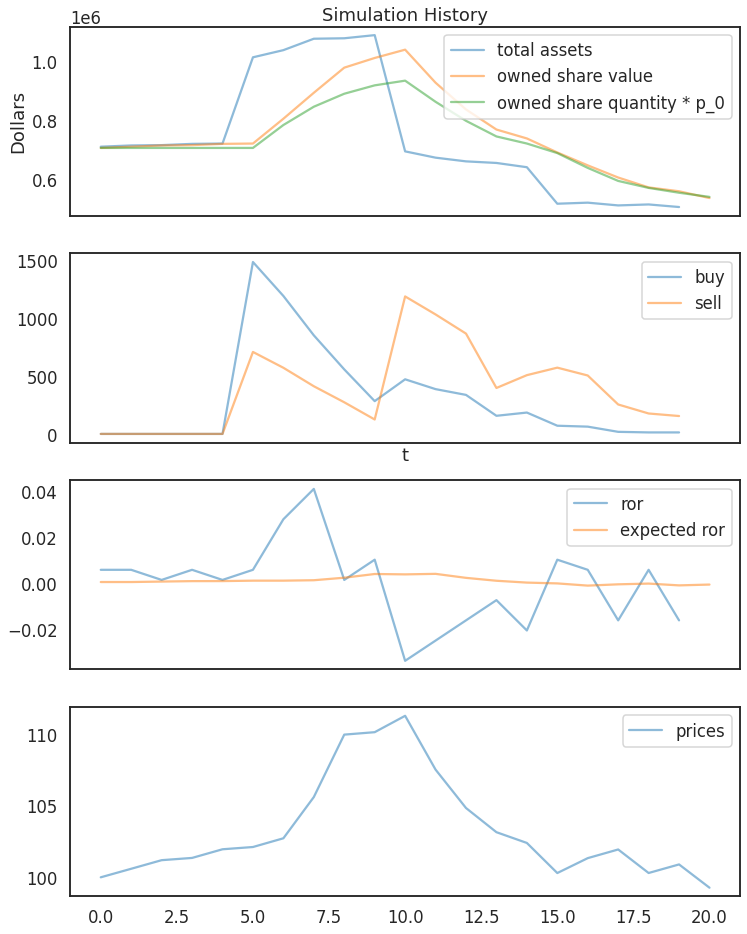

In [24]:
fig, ax = plt.subplots(
    4, 1,
    sharex='col',
    #sharey='col',
    figsize=(12,16),
)

ax[0].plot(total_asset_levels_list[1:], alpha=0.5, label='total assets')
ax[0].plot([p * o for (p,o) in zip(fm.prices, owned_shares_list)], alpha=0.5, label='owned share value')
ax[0].plot([100 * o for (p,o) in zip(fm.prices, owned_shares_list)], alpha=0.5, label='owned share quantity * p_0')
ax[0].legend()

ax[1].plot([bs[0] for bs in buy_sell_list], alpha=0.5, label='buy')
ax[1].plot([bs[1] for bs in buy_sell_list], alpha=0.5, label='sell')
ax[1].legend()

ax[2].plot(fm.ror_list, alpha=0.5, label='ror')
ax[2].plot(fm.expected_ror_list, alpha=0.5, label='expected ror')
ax[2].legend()

ax[3].plot(fm.prices, alpha=0.5, label='prices')
ax[3].legend()
    
ax[0].set_title("Simulation History")
ax[0].set_ylabel("Dollars")
ax[1].set_xlabel("t")
        
plt.show()

In [25]:
len(fm.expected_ror_list)

21

In [26]:
data = pd.DataFrame.from_dict({
    't' : range(len(fm.prices)),
    'prices' : fm.prices,
    'buy' : [None] + [bs[0] for bs in buy_sell_list],
    'sell' : [None]  + [bs[1] for bs in buy_sell_list],
    'owned' : owned_shares_list,
    'total_assets' : total_asset_levels_list,
    'ror' : [None] + fm.ror_list,
    'expected_ror' : fm.expected_ror_list,
    #'expected_ror_q' : [ror_quarterly(er, days_per_quarter) for er in expected_ror_list],
    'expected_std' : fm.expected_std_list,
    #'expected_std_q' : [sig_quarterly(es, days_per_quarter) for es in expected_std_list],
})


data

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
0,0,100.000000,NaN,NaN,7068.871716,7.068872e+05,NaN,0.000628,0.011988
1,1,100.595429,0.0,0.0,7068.871716,7.110962e+05,0.005954,0.000628,0.011988
2,2,101.194403,0.0,0.0,7068.871716,7.153303e+05,0.005954,0.000829,0.011802
3,3,101.350944,0.0,0.0,7068.871716,7.164368e+05,0.001547,0.001022,0.011614
4,4,101.954416,0.0,0.0,7068.871716,7.207027e+05,0.005954,0.001035,0.011392
5,5,102.112133,0.0,0.0,7068.871716,7.218176e+05,0.001547,0.001224,0.011208
6,6,102.720138,1489.0,710.0,7847.662488,1.014902e+06,0.005954,0.001227,0.010993
7,7,105.595382,1195.0,573.0,8469.511391,1.039254e+06,0.027991,0.001411,0.010814
8,8,109.947296,854.0,413.0,8910.740025,1.078032e+06,0.041213,0.002511,0.011773
9,9,110.117377,559.0,274.0,9195.947620,1.079597e+06,0.001547,0.004129,0.013694


In [27]:
data.corr()

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
t,1.000000,-0.094244,-0.203848,0.313108,-0.431969,-0.488195,-0.373156,-0.331091,0.845987
prices,-0.094244,1.000000,0.489697,0.260716,0.888554,0.780556,0.288951,0.879911,-0.167680
buy,-0.203848,0.489697,1.000000,0.484916,0.600906,0.721527,0.330643,0.409370,-0.394776
sell,0.313108,0.260716,0.484916,1.000000,0.292897,0.001170,-0.407951,0.277789,0.332326
owned,-0.431969,0.888554,0.600906,0.292897,1.000000,0.877759,0.236752,0.910992,-0.393227
total_assets,-0.488195,0.780556,0.721527,0.001170,0.877759,1.000000,0.538038,0.724134,-0.584844
ror,-0.373156,0.288951,0.330643,-0.407951,0.236752,0.538038,1.000000,-0.022636,-0.513699
expected_ror,-0.331091,0.879911,0.409370,0.277789,0.910992,0.724134,-0.022636,1.000000,-0.319803
expected_std,0.845987,-0.167680,-0.394776,0.332326,-0.393227,-0.584844,-0.513699,-0.319803,1.000000


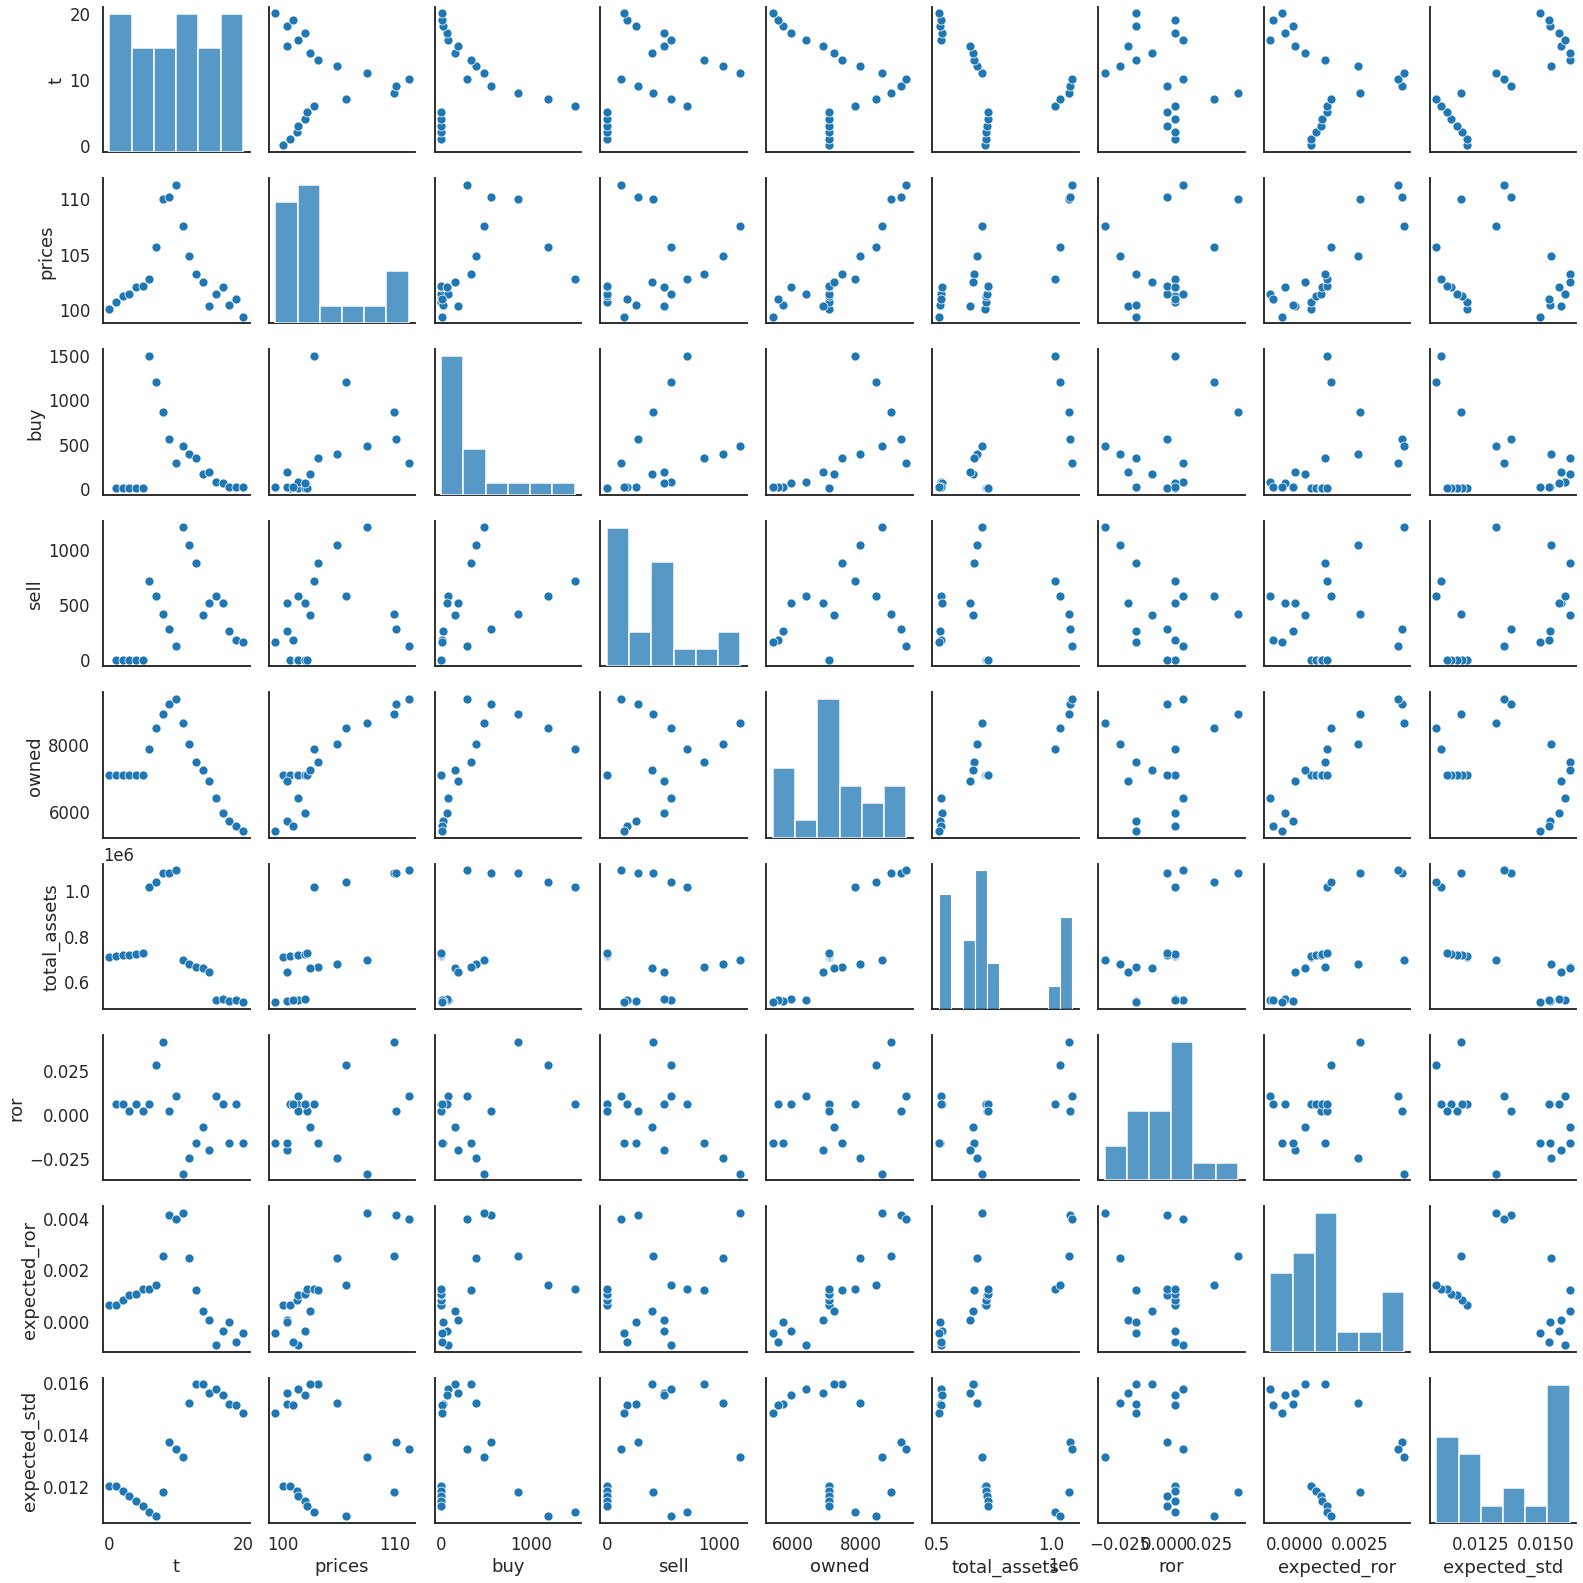

In [28]:
import seaborn as sns

sns.pairplot(data)

In [29]:
data['sell'].max()

1191.0

In [30]:
500 / 348


1.4367816091954022

<AxesSubplot:xlabel='t', ylabel='total_assets'>

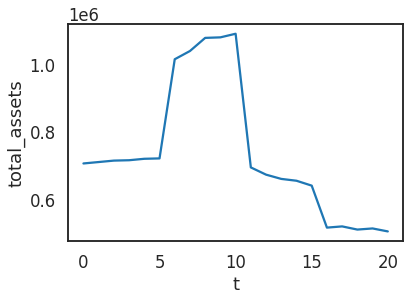

In [31]:
sns.lineplot(data= data, x = 't', y='total_assets')

<AxesSubplot:xlabel='t', ylabel='expected_ror'>

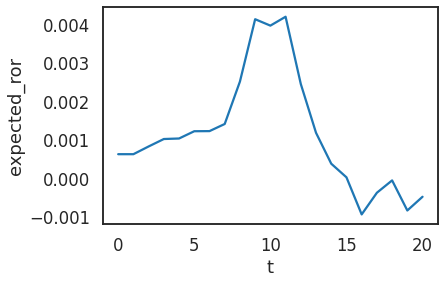

In [32]:
sns.lineplot(data= data, x = 't', y='expected_ror')

<AxesSubplot:xlabel='t', ylabel='expected_std'>

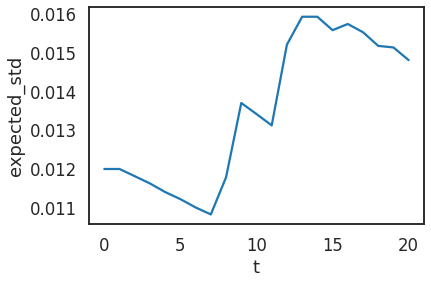

In [33]:
sns.lineplot(data= data, x = 't', y='expected_std')